In [ ]:
# Variáveis de entrada:

# X1: Área da parede externa
# X2: Área do teto
# X3: Área do piso
# X4: Altura
# X5: Orientação
# X6: Tipo de vidro
# X7: Distribuição do vidro
# X8: Transmitância do vidro

# Variáveis de saída:

# Y1: Carga térmica  de aquecimento
# Y2: Carga térmica de resfriamento

# Instalação de Pacotes

In [ ]:
!pip install prince scipy imbalanced-learn seaborn scikit-learn statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prince
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.interpolate import splrep, BSpline
from sklearn.covariance import EllipticEnvelope
from sklearn.feature_selection import chi2, SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 5.5 MB/s eta 0:00:00


# Carregamento e Pré-processamento

In [ ]:
# Carregar dados
df = pd.read_excel('ENB2012_data.xlsx', sheet_name='Φύλλο1', engine='openpyxl')

# Mapeamento de variáveis
input_features = {
    'X1': 'Área Parede Externa',
    'X2': 'Área Teto',
    'X3': 'Área Piso',
    'X4': 'Altura',
    'X5': 'Orientação',
    'X6': 'Tipo de Vidro',
    'X7': 'Distribuição Vidro',
    'X8': 'Transmitância Vidro'
}

output_targets = {
    'Y1': 'Carga Térmica Aquecimento',
    'Y2': 'Carga Térmica Resfriamento'
}

df = df.rename(columns={**input_features, **output_targets})

In [ ]:
df

,Área Parede Externa,Área Teto,Área Piso,Altura,Orientação,Tipo de Vidro,Distribuição Vidro,Transmitância Vidro,Carga Térmica Aquecimento,Carga Térmica Resfriamento
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


# Análise Exploratória


[3.1] Estatísticas Descritivas:
                            count    mean    std     min     25%     50%  \
Área Parede Externa         768.0    0.76   0.11    0.62    0.68    0.75   
Área Teto                   768.0  671.71  88.09  514.50  606.38  673.75   
Área Piso                   768.0  318.50  43.63  245.00  294.00  318.50   
Altura                      768.0  176.60  45.17  110.25  140.88  183.75   
Orientação                  768.0    5.25   1.75    3.50    3.50    5.25   
Tipo de Vidro               768.0    3.50   1.12    2.00    2.75    3.50   
Distribuição Vidro          768.0    0.23   0.13    0.00    0.10    0.25   
Transmitância Vidro         768.0    2.81   1.55    0.00    1.75    3.00   
Carga Térmica Aquecimento   768.0   22.31  10.09    6.01   12.99   18.95   
Carga Térmica Resfriamento  768.0   24.59   9.51   10.90   15.62   22.08   

                               75%     max  
Área Parede Externa           0.83    0.98  
Área Teto                   741.12  808.

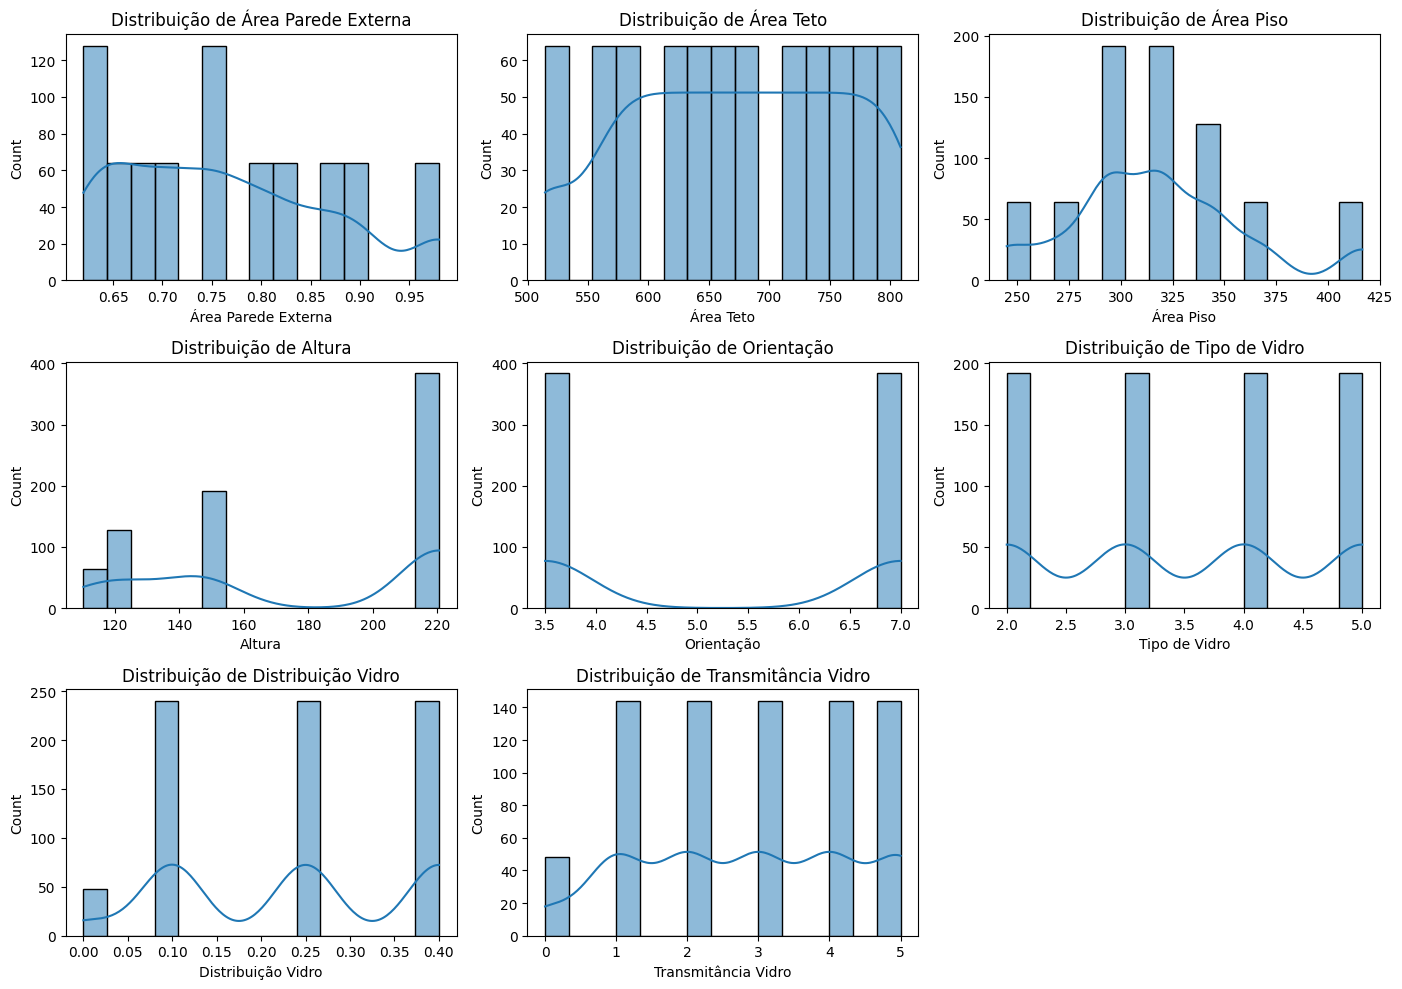

In [ ]:
# Estatísticas Descritivas
print("\n[3.1] Estatísticas Descritivas:")
print(df.describe().transpose().round(2))

# Histogramas
plt.figure(figsize=(14,10))
for i, col in enumerate(input_features.values(), 1):
    plt.subplot(3,3,i)
    sns.histplot(df[col], kde=True, bins=15)
    plt.title(f'Distribuição de {col}')
plt.tight_layout()
plt.show()

# Análise de Correlação

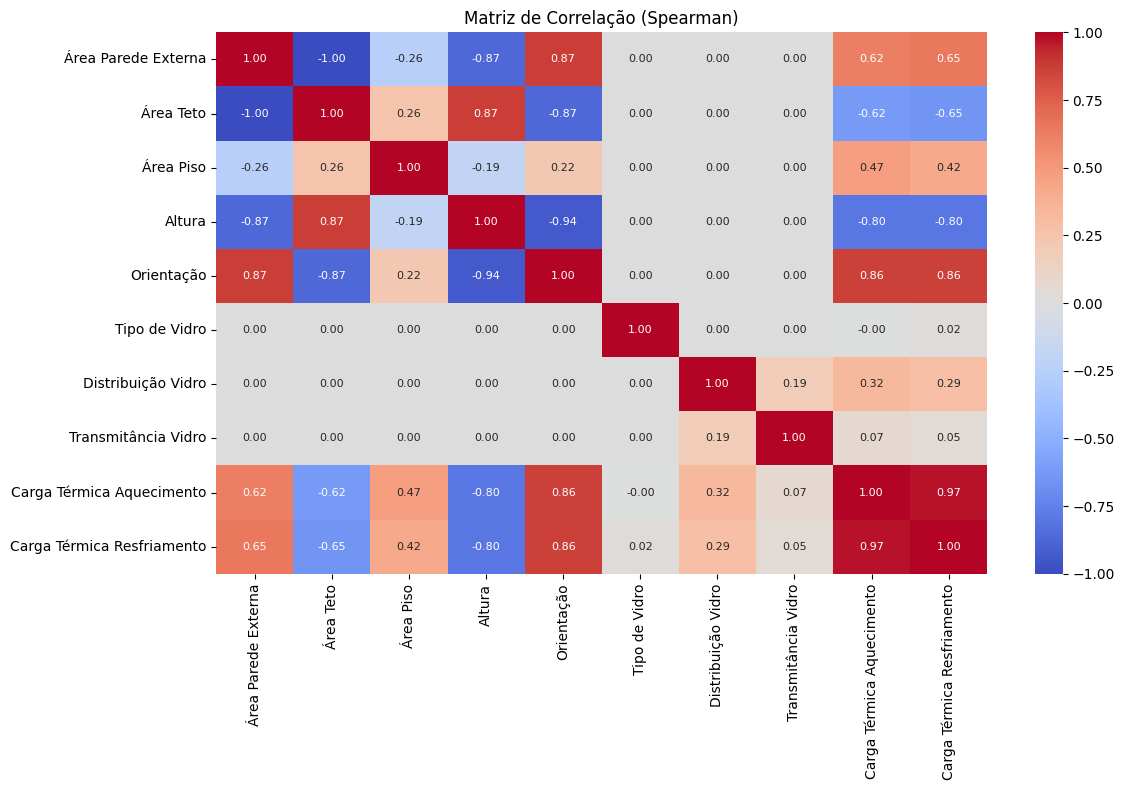

In [ ]:
# Matrizes de Correlação
methods = ['spearman']
for method in methods:
    plt.figure(figsize=(12,8))
    sns.heatmap(df.corr(method=method),
                annot=True,
                cmap='coolwarm',
                center=0,
                fmt=".2f",
                annot_kws={"size":8})
    plt.title(f'Matriz de Correlação ({method.capitalize()})')
    plt.tight_layout()
    plt.show()

Interpretação:

Fortes Correlações Positivas
- **Carga Térmica de Aquecimento e Resfriamento**

Ambientes que exigem mais energia para aquecer também tendem a exigir mais para resfriar — indicativo de ambientes com baixa eficiência térmica ou exposição solar intensa.

- **Orientação com Carga Térmica (Aquecimento e Resfriamento)**

A orientação do ambiente (provavelmente em relação ao sol) afeta fortemente a carga térmica. Ambientes mais expostos ao sol (ex: norte ou oeste) tendem a demandar mais energia.

- **Área Parede Externa com Carga Térmica**

Ambientes com maior área de parede externa têm mais troca térmica com o exterior → maior demanda térmica.

Fortes Correlações Negativas
- **Altura com Carga Térmica (Aquecimento e Resfriamento)**
Ambientes mais altos tendem a demandar menos energia térmica. Isso pode se dever à maior dispersão de calor em pé-direitos mais altos.

- **Área Teto com Carga Térmica**
Ambientes com teto maior talvez sejam mais abertos ou bem ventilados, reduzindo demanda térmica


# Análise de Outliers

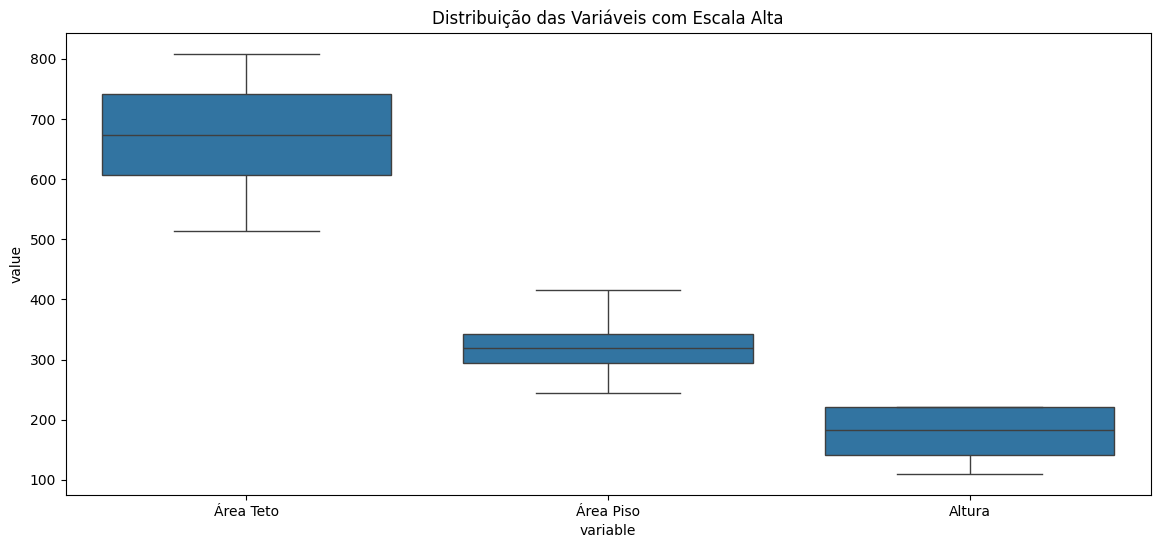

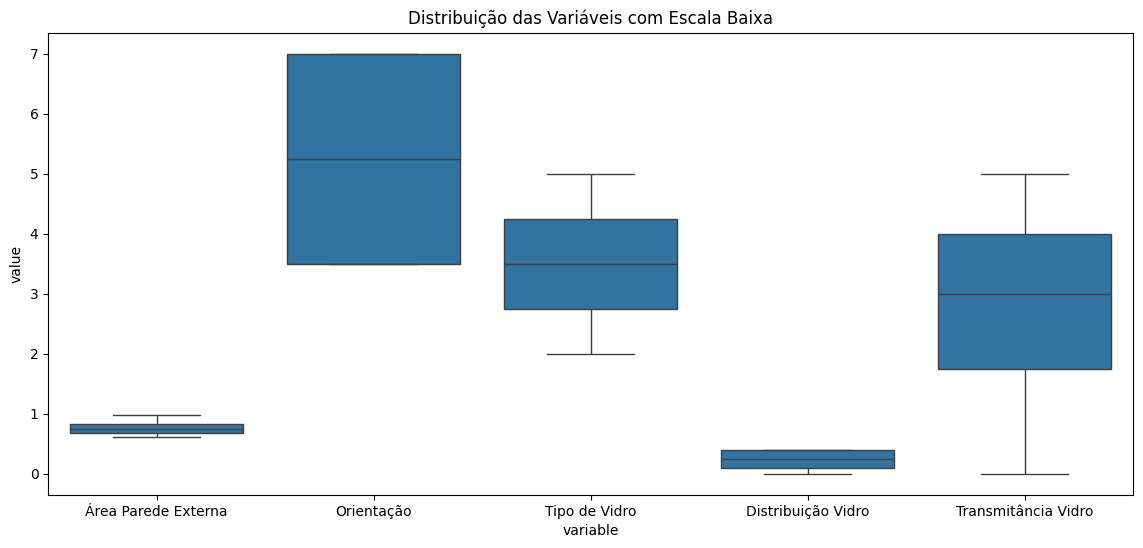

In [ ]:
# Boxplots

# Separar variáveis maiores e menores
high_range = ['Área Teto', 'Área Piso', 'Altura']
low_range = ['Área Parede Externa', 'Orientação', 'Tipo de Vidro', 'Distribuição Vidro', 'Transmitância Vidro']

# Plotar high range
plt.figure(figsize=(14, 6))
df_melt_high = pd.melt(df[high_range])
sns.boxplot(x='variable', y='value', data=df_melt_high)
plt.title('Distribuição das Variáveis com Escala Alta')
plt.show()

# Plotar low range
plt.figure(figsize=(14, 6))
df_melt_low = pd.melt(df[low_range])
sns.boxplot(x='variable', y='value', data=df_melt_low)
plt.title('Distribuição das Variáveis com Escala Baixa')
plt.show()

# Análise de Componentes Principais (PCA)

In [ ]:
# Inicialização do PCA com engine sklearn
pca = prince.PCA(
    n_components=8,
    n_iter=10,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=200
)

# Ajuste do modelo ao dataframe
pca = pca.fit(df)

# Resumo dos autovalores e variância explicada
summary = pca.eigenvalues_summary
print(summary)


          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              5.223        52.23%                     52.23%
1              1.533        15.33%                     67.56%
2              1.219        12.19%                     79.75%
3              1.000        10.00%                     89.75%
4              0.805         8.05%                     97.80%
5              0.163         1.63%                     99.43%
6              0.033         0.33%                     99.76%
7              0.019         0.19%                     99.96%


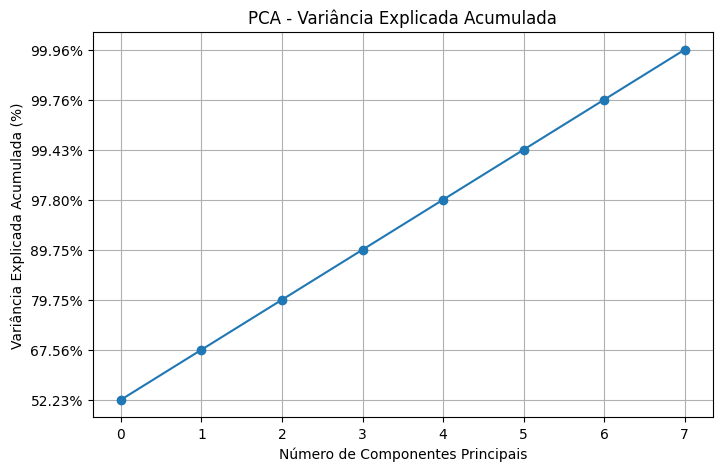

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(summary['% of variance (cumulative)'], marker='o')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada (%)')
plt.title('PCA - Variância Explicada Acumulada')
plt.grid(True)
plt.show()

In [ ]:
pca.scree_plot()

alt.Chart(...)

In [ ]:
pca.column_correlations

component,0,1,2,3,4,5,6,7
variable,,,,,,,,
Área Parede Externa,0.864412,0.468090,-0.106179,-0.000426,0.005076,-0.124730,-0.069281,0.002702
Área Teto,-0.885906,-0.448464,0.100358,0.000446,-0.003463,0.053053,0.005838,0.000302
Área Piso,0.242876,-0.847338,0.411617,0.007436,0.124533,-0.193427,-0.023396,-0.006623
Altura,-0.981180,-0.028086,-0.100931,-0.003157,-0.063521,0.145152,0.016992,0.003493
Orientação,0.980749,0.002379,0.102184,0.002894,0.056331,0.004602,0.154686,-0.016301
Tipo de Vidro,0.002557,-0.006169,0.001302,-0.999964,0.003420,-0.003374,0.000748,0.001529
Distribuição Vidro,0.105819,-0.376667,-0.713841,0.000063,-0.570859,-0.105298,0.016357,-0.010947
Transmitância Vidro,0.035383,-0.233115,-0.704699,0.002906,0.669162,-0.003056,0.000825,-0.002817
Carga Térmica Aquecimento,0.919032,-0.336619,-0.033568,0.006359,-0.069492,0.155402,-0.017876,0.107705


In [ ]:
 pca.column_contributions_.style.format('{:.0%}')

component,0,1,2,3,4,5,6,7
variable,,,,,,,,
Área Parede Externa,14%,14%,1%,0%,0%,10%,15%,0%
Área Teto,15%,13%,1%,0%,0%,2%,0%,0%
Área Piso,1%,47%,14%,0%,2%,23%,2%,0%
Altura,18%,0%,1%,0%,1%,13%,1%,0%
Orientação,18%,0%,1%,0%,0%,0%,72%,1%
Tipo de Vidro,0%,0%,0%,100%,0%,0%,0%,0%
Distribuição Vidro,0%,9%,42%,0%,40%,7%,1%,1%
Transmitância Vidro,0%,4%,41%,0%,56%,0%,0%,0%
Carga Térmica Aquecimento,16%,7%,0%,0%,1%,15%,1%,60%


# Feature selection

- Método Chi2

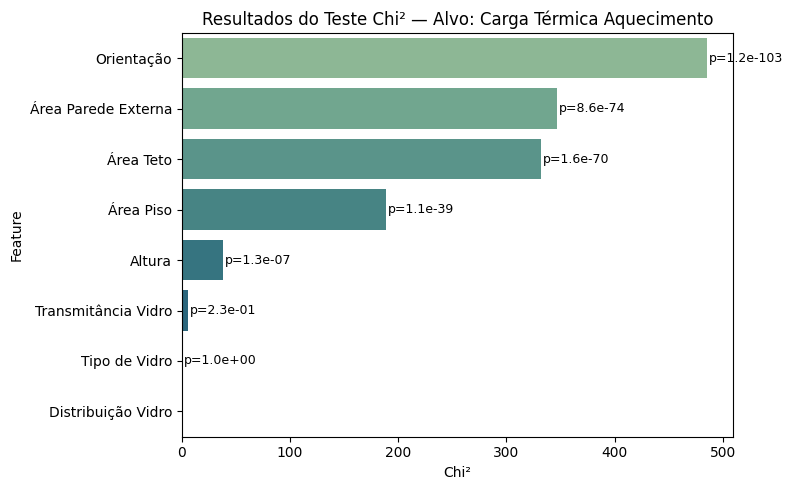

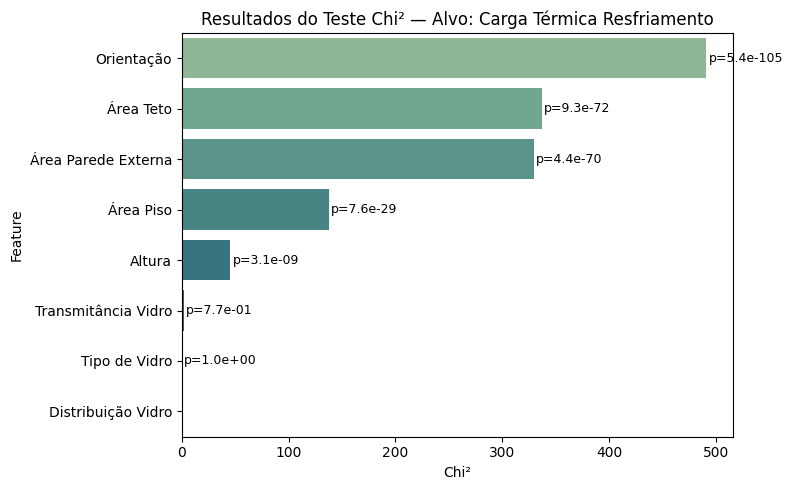

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import chi2

# 1. Discretizar variáveis contínuas
cont_vars = [
    'Área Parede Externa', 'Área Teto', 'Área Piso', 'Altura',
    'Carga Térmica Aquecimento', 'Carga Térmica Resfriamento'
]
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df_disc = df.copy()
df_disc[cont_vars] = discretizer.fit_transform(df[cont_vars])

# 2. Tratar variáveis categóricas
categorical_vars = ['Orientação', 'Tipo de Vidro', 'Transmitância Vidro','Distribuição Vidro']
df_disc[categorical_vars] = df_disc[categorical_vars].astype(int)

# 3. Função para aplicar Chi²
def run_chi2_analysis(df, features, target_label, bins=5):
    df = df.copy()
    df['Y_binned'] = pd.qcut(df[target_label].rank(method='first'), q=bins, labels=False, duplicates='drop')
    X = df[features]
    y = df['Y_binned']

    chi2_vals, p_vals = chi2(X, y)
    result = pd.DataFrame({
        'Feature': features,
        'Chi2': chi2_vals,
        'p-value': p_vals
    }).sort_values(by='Chi2', ascending=False).reset_index(drop=True)

    return result

# 4. Executar análises para dois alvos
features = cont_vars[:4] + categorical_vars  # exclui os alvos das features
resultado_aquec = run_chi2_analysis(df_disc, features, 'Carga Térmica Aquecimento')
resultado_resfri = run_chi2_analysis(df_disc, features, 'Carga Térmica Resfriamento')

# 5. Função para plotar como na imagem
def plot_chi2_result(df_result, titulo):
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_result, x='Chi2', y='Feature', palette='crest')

    for i, row in df_result.iterrows():
        plt.text(row['Chi2'] + 2, i, f"p={row['p-value']:.1e}", va='center', fontsize=9)

    plt.title(f"Resultados do Teste Chi² — Alvo: {titulo}")
    plt.xlabel("Chi²")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# 6. Plotar ambos
plot_chi2_result(resultado_aquec, "Carga Térmica Aquecimento")
plot_chi2_result(resultado_resfri, "Carga Térmica Resfriamento")


- LASSO

In [ ]:
# Verificar compatibilidade da versão do sklearn
if version.parse(sklearn_version) >= version.parse("1.2"):
    encoder = OneHotEncoder(drop='first', sparse_output=False)
else:
    encoder = OneHotEncoder(drop='first', sparse=False)

# === 1. DEFINIÇÕES INICIAIS ===

# Alvo
target = 'Carga Térmica Aquecimento'
y = df[target]

# Variáveis contínuas
num_features = ['Área Parede Externa', 'Área Teto', 'Área Piso', 'Altura']

# Variáveis categóricas numéricas (apesar de numéricas, são qualitativas)
cat_features = ['Orientação', 'Tipo de Vidro', 'Distribuição Vidro', 'Transmitância Vidro']

# Dados preditores
X = df[num_features + cat_features]

# === 2. PIPELINE: SCALER + ONE-HOT + LASSO ===

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', encoder, cat_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(LassoCV(cv=5, random_state=42)))
])

# Ajustar pipeline
pipeline.fit(X, y)

# === 3. EXTRAÇÃO DAS FEATURES SELECIONADAS ===

# Obter nomes das features transformadas
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(cat_features)
all_transformed_features = np.concatenate([num_features, ohe_feature_names])

# Máscara de seleção do LASSO
mask = pipeline.named_steps['selector'].get_support()
selected_expanded = all_transformed_features[mask]
removed_expanded = all_transformed_features[~mask]

# === 4. AGRUPAR NOMES ORIGINAIS ===

# Mapeamento de categorias para colunas expandidas
cat_map = defaultdict(list)
for name in ohe_feature_names:
    for col in cat_features:
        if name.startswith(col + "_"):
            cat_map[col].append(name)

# Separar selecionadas/removidas em nomes originais
selected_final = set()
removed_final = set()

# Numéricas
for num in num_features:
    if num in selected_expanded:
        selected_final.add(num)
    else:
        removed_final.add(num)

# Categóricas
for cat in cat_features:
    cols = cat_map.get(cat, [])
    if len(cols) == 0:
        removed_final.add(cat)
    elif any(col in selected_expanded for col in cols):
        selected_final.add(cat)
    else:
        removed_final.add(cat)

# === 5. RESULTADO FINAL ===

print("✅ Variáveis selecionadas com LASSO:")
print(sorted(selected_final))

print("\n❌ Variáveis removidas com LASSO:")
print(sorted(removed_final))


✅ Variáveis selecionadas com LASSO:
['Altura', 'Orientação', 'Tipo de Vidro', 'Transmitância Vidro', 'Área Parede Externa', 'Área Piso', 'Área Teto']

❌ Variáveis removidas com LASSO:
['Distribuição Vidro']


# Árvore de decisão (Regressão)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image

In [ ]:
# 1. Carregar dados do Excel
df = pd.read_excel('ENB2012_data.xlsx', sheet_name='Φύλλο1', engine='openpyxl')

# 2. Renomear colunas
input_features = {
    'X1': 'Área Parede Externa',
    'X2': 'Área Teto',
    'X3': 'Área Piso',
    'X4': 'Altura',
    'X5': 'Orientação',
    'X6': 'Tipo de Vidro',
    'X7': 'Distribuição Vidro',
    'X8': 'Transmitância Vidro'
}

output_targets = {
    'Y1': 'Carga Térmica Aquecimento',
    'Y2': 'Carga Térmica Resfriamento'
}

df = df.rename(columns={**input_features, **output_targets})

# 3. Separar entrada e saída
entrada = df[list(input_features.values())]
saida = df[['Carga Térmica Aquecimento']]  # troque para 'Carga Térmica Resfriamento' se desejar


In [ ]:
# 4. Divisão treino/teste com nomenclatura personalizada
train_ent, test_ent, train_sai, test_sai = train_test_split(entrada, saida, test_size=0.3, random_state=42)

In [ ]:
# 5. GridSearch para ajuste de parâmetros
parametros = {
    'criterion': ["squared_error", "friedman_mse", "absolute_error"],
    'max_depth': [3, 5, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 3, 5]
}

In [ ]:
grid = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=parametros, cv=5)
grid.fit(train_ent, train_sai)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error'],
                         'max_depth': [3, 5, 4], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 4]})

In [ ]:
# 6. Resultados da validação cruzada
print(pd.DataFrame(grid.cv_results_)[['params','rank_test_score','mean_test_score']])
best_params = grid.best_params_

                                               params  rank_test_score  \
0   {'criterion': 'squared_error', 'max_depth': 3,...               37   
1   {'criterion': 'squared_error', 'max_depth': 3,...               37   
2   {'criterion': 'squared_error', 'max_depth': 3,...               37   
3   {'criterion': 'squared_error', 'max_depth': 3,...               37   
4   {'criterion': 'squared_error', 'max_depth': 3,...               37   
5   {'criterion': 'squared_error', 'max_depth': 3,...               37   
6   {'criterion': 'squared_error', 'max_depth': 5,...                3   
7   {'criterion': 'squared_error', 'max_depth': 5,...                1   
8   {'criterion': 'squared_error', 'max_depth': 5,...                9   
9   {'criterion': 'squared_error', 'max_depth': 5,...                9   
10  {'criterion': 'squared_error', 'max_depth': 5,...                6   
11  {'criterion': 'squared_error', 'max_depth': 5,...                5   
12  {'criterion': 'squared_error', 'ma

In [ ]:
print("Melhores parâmetros:", best_params)

Melhores parâmetros: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [ ]:
# 6. Treinar modelo final com os melhores parâmetros
model = DecisionTreeRegressor(**grid.best_params_)
model.fit(train_ent, train_sai)

DecisionTreeRegressor(max_depth=5, min_samples_split=4)

In [ ]:
# 7. Visualizar árvore de decisão
dot_data = export_graphviz(model, feature_names=entrada.columns, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())
graph.write_png("arvore_decisao.png")

True

In [ ]:
# 8. Avaliar no treino
pred_train = model.predict(train_ent)

r2_train = r2_score(train_sai, pred_train)
print("R² no treino:", r2_train)

# erro_train = train_sai.values.flatten() - pred_train
# sse_train = np.sum(erro_train**2)
# print("SSE no treino:", sse_train)

mse_train = mean_squared_error(train_sai, pred_train)
print("MSE no treino:", mse_train)

R² no treino: 0.9911552954578272
MSE no treino: 0.8984627630376358


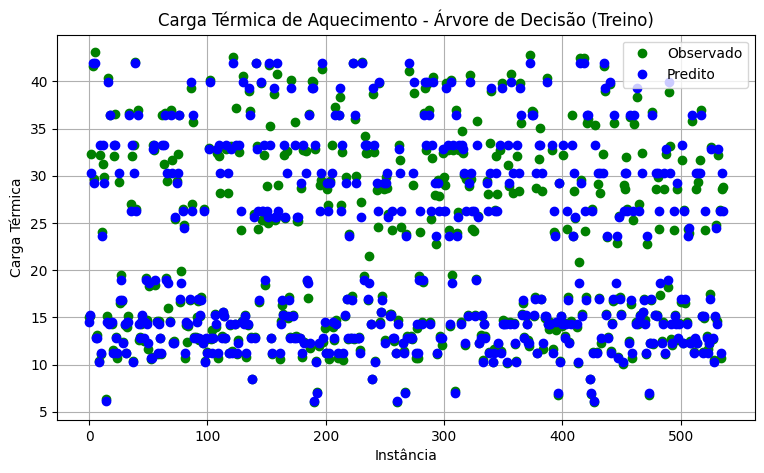

In [ ]:
# 9. Gráfico - Observado vs Predito (treino)
plt.figure(figsize=(9,5))
x = np.arange(len(train_sai))
plt.plot(x, train_sai.values, 'go', label='Observado')
plt.plot(x, pred_train, 'bo', label='Predito')
plt.title("Carga Térmica de Aquecimento - Árvore de Decisão (Treino)")
plt.xlabel("Instância")
plt.ylabel("Carga Térmica")
plt.grid(True)
plt.legend()
plt.show()

## Testando o modelo

In [ ]:
# Avaliar no teste
pred_test = model.predict(test_ent)
r2_test = r2_score(test_sai, pred_test)
print("R² no teste:", r2_test)

# erro_test = test_sai.values.flatten() - pred_test
# sse_test = np.sum(erro_test**2)
# print("SSE no teste:", sse_test)

mse_test = mean_squared_error(test_sai, pred_test)
print("MSE no teste:", mse_test)

R² no teste: 0.9882275514787319
MSE no teste: 1.1936956004746362


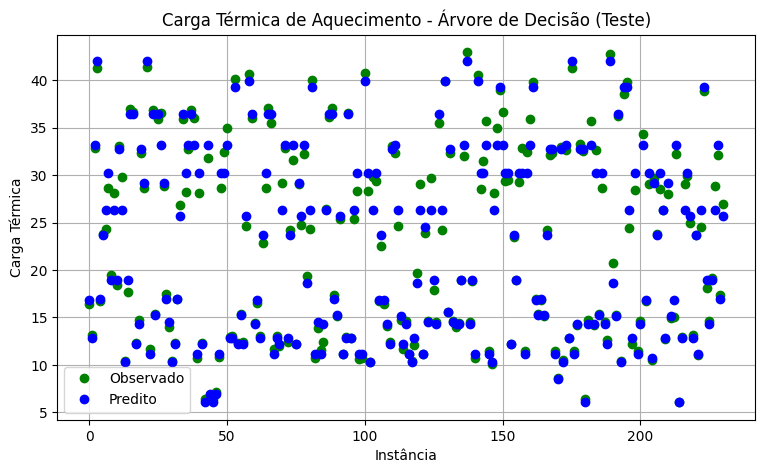

In [ ]:
# Gráfico - Observado vs Predito (teste)
plt.figure(figsize=(9,5))
x_test = np.arange(len(test_sai))
plt.plot(x_test, test_sai.values, 'go', label='Observado')
plt.plot(x_test, pred_test, 'bo', label='Predito')
plt.title("Carga Térmica de Aquecimento - Árvore de Decisão (Teste)")
plt.xlabel("Instância")
plt.ylabel("Carga Térmica")
plt.grid(True)
plt.legend()
plt.show()

# **Redes Neurais (Regressão)**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [4]:
# 1. Carregar os dados e renomear colunas
df = pd.read_excel('ENB2012_data.xlsx', sheet_name='Φύλλο1', engine='openpyxl')

#Dica: diminuir o numero de variável e analisar
# 2. Mapeamento de colunas
input_features = {
    'X1': 'Área Parede Externa',
    'X2': 'Área Teto',
    'X3': 'Área Piso',
    'X4': 'Altura',
    'X5': 'Orientação',
    'X6': 'Tipo de Vidro',
    'X7': 'Distribuição Vidro',
    'X8': 'Transmitância Vidro'
}

output_targets = {
    'Y1': 'Carga Térmica Aquecimento',
    'Y2': 'Carga Térmica Resfriamento'
}

df = df.rename(columns={**input_features, **output_targets})

# 3. Definir variáveis de entrada e saída
entrada = df[list(input_features.values())]
saida = df[['Carga Térmica Aquecimento']]  # ou 'Carga Térmica Resfriamento'

In [5]:
# 4. Dividir em treino e teste
train_ent, test_ent, train_sai, test_sai = train_test_split(entrada, saida, test_size=0.3, random_state=42)

In [6]:
# 5. Normalização dos dados de entrada (entre -1 e 1)
scaler1 = MinMaxScaler(feature_range=(-1, 1))
train_entn = scaler1.fit_transform(train_ent)

In [7]:
# 6. Normalização dos dados de saída
scaler2 = MinMaxScaler(feature_range=(-1, 1))
train_sain = scaler2.fit_transform(train_sai)
train_sain = np.ravel(train_sain)  # necessário para o MLP

In [8]:
# 7. Ajuste com GridSearchCV
parametros = [{
    'hidden_layer_sizes': [(8,), (9,), (12,)],
    'activation': ["logistic", "tanh"],
    'solver': ["lbfgs", "sgd", "adam"],
    'learning_rate': ["constant", "adaptive"]
}]

In [9]:
grid = GridSearchCV(estimator=MLPRegressor(max_iter=1000),
                    param_grid=parametros,
                    scoring='r2',
                    cv=5)
grid.fit(train_entn, train_sain)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=1000),
             param_grid=[{'activation': ['logistic', 'tanh'],
                          'hidden_layer_sizes': [(8,), (9,), (12,)],
                          'learning_rate': ['constant', 'adaptive'],
                          'solver': ['lbfgs', 'sgd', 'adam']}],
             scoring='r2')

In [10]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.303126,0.154726,0.003331,0.003321,logistic,"(8,)",constant,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.995076,0.996429,0.989804,0.988363,0.988390,0.991612,0.003447,12
1,0.383916,0.062756,0.001688,0.000118,logistic,"(8,)",constant,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.802361,0.763436,0.734132,0.829775,0.835879,0.793117,0.039033,31
2,0.198101,0.094157,0.001269,0.000204,logistic,"(8,)",constant,adam,"{'activation': 'logistic', 'hidden_layer_sizes...",0.902942,0.842111,0.876816,0.887827,0.850414,0.872022,0.022761,20
3,0.242238,0.030320,0.001522,0.000135,logistic,"(8,)",adaptive,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.995357,0.997143,0.990078,0.997663,0.983398,0.992728,0.005382,11
4,0.323130,0.040863,0.001237,0.000103,logistic,"(8,)",adaptive,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.824836,0.740524,0.751251,0.770633,0.810511,0.779551,0.032902,34
5,0.146743,0.020827,0.001088,0.000014,logistic,"(8,)",adaptive,adam,"{'activation': 'logistic', 'hidden_layer_sizes...",0.894416,0.871778,0.882866,0.859499,0.853069,0.872326,0.015065,17
6,0.241841,0.037115,0.001468,0.000048,logistic,"(9,)",constant,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.995983,0.996216,0.991080,0.997482,0.996507,0.995453,0.002246,7
7,0.270748,0.028038,0.001136,0.000037,logistic,"(9,)",constant,sgd,"{'activation': 'logistic', 'hidden_layer_sizes...",0.795945,0.739195,0.787185,0.758160,0.824742,0.781046,0.029814,33
8,0.148304,0.034343,0.001233,0.000204,logistic,"(9,)",constant,adam,"{'activation': 'logistic', 'hidden_layer_sizes...",0.901373,0.818101,0.881508,0.884366,0.846777,0.866425,0.029973,23
9,0.268498,0.086944,0.001507,0.000095,logistic,"(9,)",adaptive,lbfgs,"{'activation': 'logistic', 'hidden_layer_sizes...",0.995234,0.996996,0.995391,0.992014,0.997312,0.995389,0.001881,8


In [11]:
# 8. Resultados da busca
print(pd.DataFrame(grid.cv_results_)[['params','rank_test_score','mean_test_score']])
print("Melhores parâmetros encontrados:", grid.best_params_)

                                               params  rank_test_score  \
0   {'activation': 'logistic', 'hidden_layer_sizes...               12   
1   {'activation': 'logistic', 'hidden_layer_sizes...               31   
2   {'activation': 'logistic', 'hidden_layer_sizes...               20   
3   {'activation': 'logistic', 'hidden_layer_sizes...               11   
4   {'activation': 'logistic', 'hidden_layer_sizes...               34   
5   {'activation': 'logistic', 'hidden_layer_sizes...               17   
6   {'activation': 'logistic', 'hidden_layer_sizes...                7   
7   {'activation': 'logistic', 'hidden_layer_sizes...               33   
8   {'activation': 'logistic', 'hidden_layer_sizes...               23   
9   {'activation': 'logistic', 'hidden_layer_sizes...                8   
10  {'activation': 'logistic', 'hidden_layer_sizes...               36   
11  {'activation': 'logistic', 'hidden_layer_sizes...               21   
12  {'activation': 'logistic', 'hidden

In [12]:
# 9. Treinar modelo final com melhor combinação
model = MLPRegressor(
    hidden_layer_sizes=grid.best_params_['hidden_layer_sizes'],
    activation=grid.best_params_['activation'],
    solver='adam',
    learning_rate=grid.best_params_['learning_rate'],
    max_iter=1000
)

model.fit(train_entn, train_sain)

MLPRegressor(activation='tanh', hidden_layer_sizes=(9,), max_iter=1000)

In [ ]:
grid.best_params_['hidden_layer_sizes']

(9,)

In [ ]:
grid.best_params_['activation']

'tanh'

In [ ]:
grid.best_params_['activation']

'tanh'

In [ ]:
grid.best_params_['learning_rate']

'adaptive'

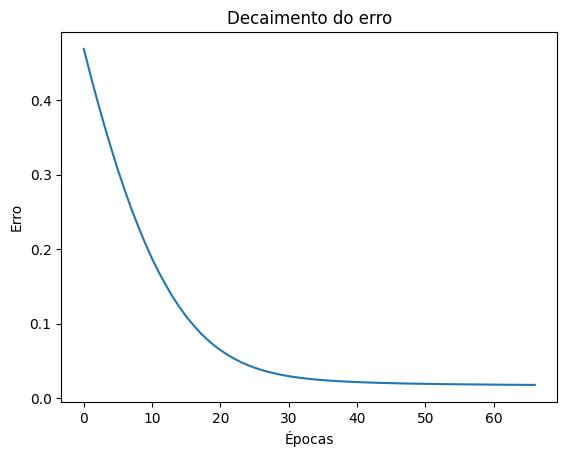

In [13]:
# 10. Curva de erro
plt.plot(model.loss_curve_)
plt.title('Decaimento do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.show()

In [14]:
# Vetores de saída do modelo MLP
pred_trainn = model.predict(train_entn)

In [15]:
#Desnormalizar os dados
pred_trainn_ = pd.DataFrame(pred_trainn)
saida_des_pred = scaler2.inverse_transform(pred_trainn_) #Usando o valores máximos e mínimos definidos pelos vetores reais.
#print(saida_des_pred)

In [16]:
# R² e SSE no treino
r2_train = r2_score(train_sai, saida_des_pred)
print("R² no treino:", r2_train)

erro = train_sai.values.flatten() - saida_des_pred.flatten()
mse = np.mean(erro**2)
print("MSE no treino:", mse)

R² no treino: 0.8792187391567148
MSE no treino: 12.269201851005983


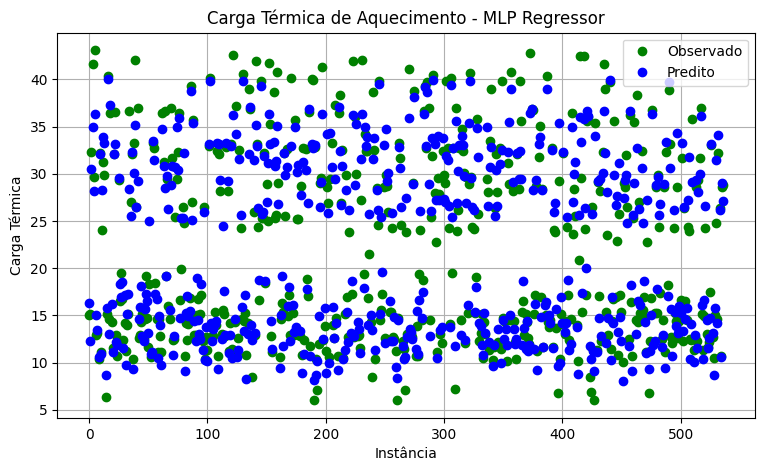

In [ ]:
# Gráfico de observados vs preditos
x = np.array(range(len(train_sai)))
plt.figure(figsize=(9, 5))
plt.plot(x, np.ravel(train_sai), 'go', label='Observado')
plt.plot(x, np.ravel(saida_des_pred), 'bo', label='Predito')
plt.title("Carga Térmica de Aquecimento - MLP Regressor")
plt.xlabel("Instância")
plt.ylabel("Carga Térmica")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#Pesos e Bias
pesos = model.coefs_
bias = model.intercepts_

print("Pesos:", pesos)
print("Bias:", bias)

Pesos: [array([[ 0.4668283 ,  0.0663539 ,  0.57180017,  0.44551216, -0.33824042,
        -0.25575468, -0.11064015,  0.12379624,  0.19021175],
       [ 0.22983162, -0.46079571, -0.06984462,  0.02742517,  0.36351729,
        -0.6425793 , -0.06280725, -0.35674344, -0.49991299],
       [-0.03906792,  0.02552624,  0.6213838 ,  0.01496191, -0.17983978,
         0.91594561,  0.24961785, -0.03705927,  0.06205585],
       [-0.73609549,  0.26744789,  0.01617149,  0.31883137, -0.1905087 ,
         0.02372015, -0.39587282,  0.21805281, -0.2383093 ],
       [-0.03717453,  0.35528098,  0.68002723,  0.41372294, -0.10363254,
        -0.22664554, -0.52442792, -0.33772231,  0.32963801],
       [-0.24568375, -0.61443915,  0.37495691, -0.2049371 , -0.33431665,
         0.27647524, -0.42835316, -0.00745387, -0.05899695],
       [ 0.03334051, -0.1181004 , -0.32639461, -0.57471801,  0.69401034,
        -0.07707361,  0.01032823, -0.37746283,  0.40045544],
       [ 0.13159268, -0.65628648, -0.22727094, -0.5636

## Testando o modelo

**Predição do modelo dados de teste**

In [ ]:
# 1. Normalizar os dados de entrada do teste com o mesmo scaler usado no treino
test_entn = scaler1.transform(test_ent)

# 2. Gerar predições normalizadas no conjunto de teste
pred_testn = model.predict(test_entn)

In [ ]:
# 3. Desnormalizar os resultados
pred_testn_ = pd.DataFrame(pred_testn)
saida_des_pred_test = scaler2.inverse_transform(pred_testn_)

In [ ]:
# 4. Avaliar o desempenho no teste
from sklearn.metrics import r2_score

r2_test = r2_score(test_sai, saida_des_pred_test)
print("R² no teste:", r2_test)
erro_test = test_sai.values.flatten() - saida_des_pred_test.flatten()
sse_test = np.sum(erro_test**2)
print("SSE no teste:", sse_test)

R² no teste: 0.8753312333040386
SSE no teste: 2920.091339552447


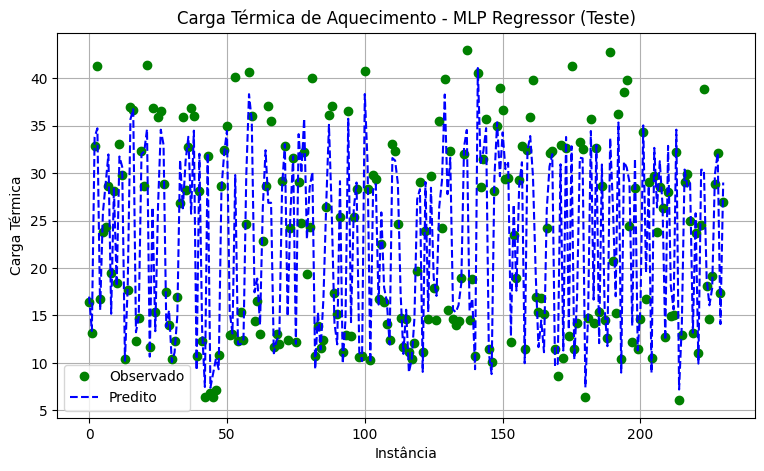

In [ ]:
# Gráfico de observados vs preditos (teste)
import matplotlib.pyplot as plt

x_test = np.arange(len(test_sai))
plt.figure(figsize=(9, 5))
plt.plot(x_test, test_sai.values, 'go', label='Observado')
plt.plot(x_test, saida_des_pred_test, 'b--', label='Predito')
plt.title("Carga Térmica de Aquecimento - MLP Regressor (Teste)")
plt.xlabel("Instância")
plt.ylabel("Carga Térmica")
plt.grid(True)
plt.legend()
plt.show()

# **SVM (Regressão)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel('ENB2012_data.xlsx', sheet_name='Φύλλο1', engine='openpyxl')

# Mapeamento de variáveis
input_features = {
    'X1': 'Área Parede Externa',
    'X2': 'Área Teto',
    'X3': 'Área Piso',
    'X4': 'Altura',
    'X5': 'Orientação',
    'X6': 'Tipo de Vidro',
    'X7': 'Distribuição Vidro',
    'X8': 'Transmitância Vidro'
}

output_targets = {
    'Y1': 'Carga Térmica Aquecimento',
    'Y2': 'Carga Térmica Resfriamento'
}

df = df.rename(columns={**input_features, **output_targets})

In [ ]:
# Variáveis de entrada
X = df[list(input_features.values())]

# Variável de saída (você pode trocar por 'Carga Térmica Resfriamento')
y = df[['Carga Térmica Aquecimento']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
# 4. Normalização

# Entrada
scaler_X = MinMaxScaler(feature_range=(-1, 1))
X_train_norm = scaler_X.fit_transform(X_train)

# Saída
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_norm = scaler_y.fit_transform(y_train)
y_train_norm = np.ravel(y_train_norm)  # necessário para o SVM

In [ ]:
# 5. Treinamento com GridSearchCV

model_base = svm.SVR()
param_grid = {
    'C': [0.2, 0.5, 1],
    'kernel': ["linear", "sigmoid", "rbf"]
}

In [ ]:
grid = GridSearchCV(estimator=model_base, param_grid=param_grid, cv=5)
grid.fit(X_train_norm, y_train_norm)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.2, 0.5, 1],
                         'kernel': ['linear', 'sigmoid', 'rbf']})

In [ ]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023611,0.001439,0.002418,0.000103,0.2,linear,"{'C': 0.2, 'kernel': 'linear'}",0.910943,0.892094,0.916312,0.915761,0.897328,0.906488,0.009934,6
1,0.030616,0.002314,0.005796,0.000855,0.2,sigmoid,"{'C': 0.2, 'kernel': 'sigmoid'}",-0.494150,-0.040534,-0.211543,0.149161,-0.805176,-0.280449,0.337010,7
2,0.010521,0.001471,0.004014,0.001066,0.2,rbf,"{'C': 0.2, 'kernel': 'rbf'}",0.926366,0.911477,0.903486,0.932083,0.927586,0.920199,0.010856,3
3,0.029569,0.003781,0.002392,0.000103,0.5,linear,"{'C': 0.5, 'kernel': 'linear'}",0.914726,0.894719,0.916880,0.919028,0.896049,0.908280,0.010626,5
4,0.033908,0.003339,0.006009,0.000135,0.5,sigmoid,"{'C': 0.5, 'kernel': 'sigmoid'}",-6.438025,-7.244889,-6.623103,-4.699537,-9.438191,-6.888749,1.529239,8
5,0.012657,0.000652,0.003082,0.000095,0.5,rbf,"{'C': 0.5, 'kernel': 'rbf'}",0.933295,0.920686,0.910942,0.940826,0.926775,0.926505,0.010270,2
6,0.025194,0.008830,0.001969,0.000663,1.0,linear,"{'C': 1, 'kernel': 'linear'}",0.914294,0.895127,0.916834,0.922185,0.895213,0.908730,0.011361,4
7,0.017923,0.001390,0.003819,0.000083,1.0,sigmoid,"{'C': 1, 'kernel': 'sigmoid'}",-35.568257,-32.136403,-39.028375,-22.115616,-41.419607,-34.053651,6.745246,9
8,0.008298,0.000366,0.001725,0.000038,1.0,rbf,"{'C': 1, 'kernel': 'rbf'}",0.939322,0.926368,0.919265,0.942026,0.924540,0.930304,0.008824,1


In [ ]:
print(pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'rank_test_score']])


                            params  mean_test_score  rank_test_score
0   {'C': 0.2, 'kernel': 'linear'}         0.906488                6
1  {'C': 0.2, 'kernel': 'sigmoid'}        -0.280449                7
2      {'C': 0.2, 'kernel': 'rbf'}         0.920199                3
3   {'C': 0.5, 'kernel': 'linear'}         0.908280                5
4  {'C': 0.5, 'kernel': 'sigmoid'}        -6.888749                8
5      {'C': 0.5, 'kernel': 'rbf'}         0.926505                2
6     {'C': 1, 'kernel': 'linear'}         0.908730                4
7    {'C': 1, 'kernel': 'sigmoid'}       -34.053651                9
8        {'C': 1, 'kernel': 'rbf'}         0.930304                1


In [ ]:
# 6. Modelo final com melhores hiperparâmetros
# =======================
best_model = svm.SVR(C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
best_model.fit(X_train_norm, y_train_norm)

SVR(C=1)

In [ ]:
# 7. Predição

y_pred_norm = best_model.predict(X_train_norm)

# Desnormalização
y_pred = scaler_y.inverse_transform(pd.DataFrame(y_pred_norm))

In [ ]:
# 8. Avaliação

r2 = r2_score(y_train, y_pred)
print(f"R² do treinamento: {r2:.4f}")

R² do treinamento: 0.9511


In [ ]:
# Erro quadrático
erro = y_train.values - y_pred
mse = np.mean(erro**2)
print(f"MSE do treinamento: {mse:.2f}")

MSE do treinamento: 4.97


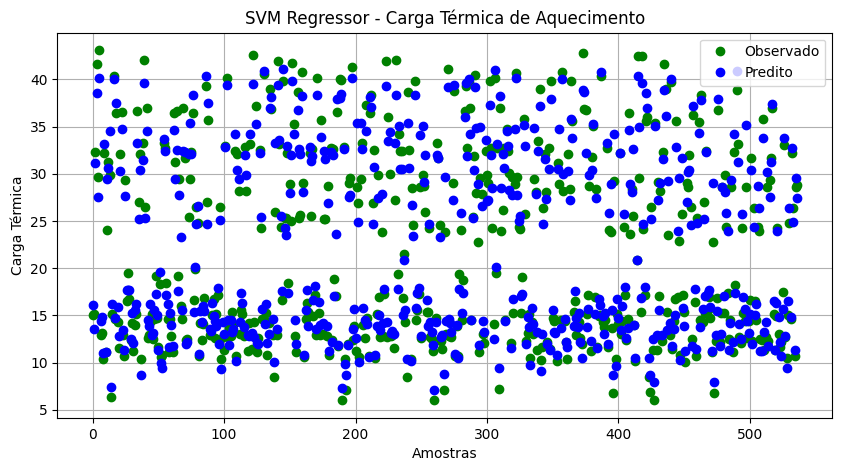

In [ ]:
# 9. Visualização

x = np.arange(len(y_train))

plt.figure(figsize=(10,5))
plt.plot(x, y_train.values, 'go', label='Observado')
plt.plot(x, y_pred, 'bo', label='Predito')
plt.legend()
plt.title("SVM Regressor - Carga Térmica de Aquecimento")
plt.xlabel("Amostras")
plt.ylabel("Carga Térmica")
plt.grid(True)
plt.show()

## Testando o modelo

In [ ]:
# Normalizar entradas de teste com o mesmo scaler usado no treino
X_test_norm = scaler_X.transform(X_test)

In [ ]:
# Prever e desnormalizar
y_test_pred_norm = best_model.predict(X_test_norm)
y_test_pred = scaler_y.inverse_transform(pd.DataFrame(y_test_pred_norm))

In [ ]:
# Avaliação no conjunto de teste
r2_test = r2_score(y_test, y_test_pred)
print(f"R² do teste: {r2_test:.4f}")

R² do teste: 0.9450


In [ ]:
# SSE no conjunto de teste
erro_test = y_test.values - y_test_pred
sse_test = np.sum(erro_test**2)
print(f"SSE do teste: {sse_test:.2f}")

SSE do teste: 1289.14


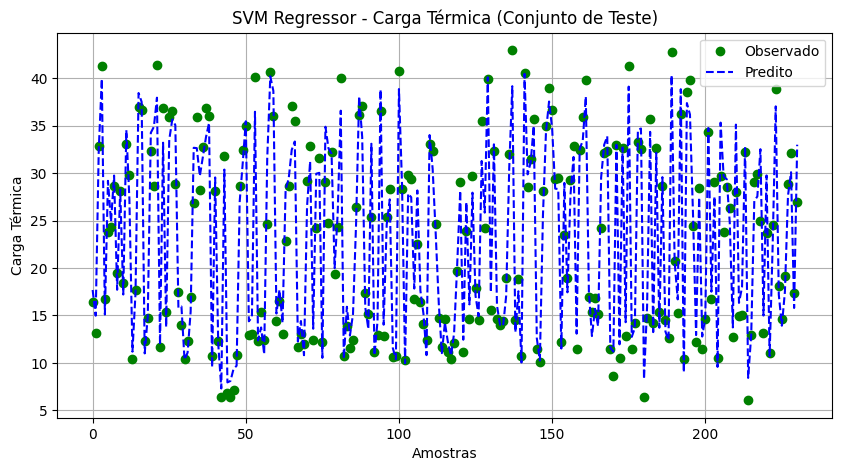

In [ ]:
# Gráfico do teste
x_test = np.arange(len(y_test))

plt.figure(figsize=(10,5))
plt.plot(x_test, y_test.values, 'go', label='Observado')
plt.plot(x_test, y_test_pred, 'b--', label='Predito')
plt.legend()
plt.title("SVM Regressor - Carga Térmica (Conjunto de Teste)")
plt.xlabel("Amostras")
plt.ylabel("Carga Térmica")
plt.grid(True)
plt.show()